# Tutorial 4.2 - Model Selection

This tutorial is partially based on the Python Data Science Handbook by Jake VanderPlas and the Jupyter notebooks available on GitHub at https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html. 

Choosing a class of model and the model hyperparameters are one of the most important parts for applying machine learning effectively. To make an informed choice, we need a way to validate that our model and our hyperparameters are a good fit to the data. While this may sound simple, there are some pitfalls that you must avoid to do this effectively.

**Expected Tasks**

- Follow the evaluation methods showcase.
- Play with the different evaluation method variants. 

**Learning Objectives**

- Choosing the right evaluation method metric according to your task and data. 
- Running an evaluation method in scikit-learn, given a certain evaluation method.
- Fine-tuning the hyper-parameter values of a machine-learning model. 

**Notes**

Evaluation methods are demonstrated in this notebook using small code recipes in Python and scikit-learn.

More information on theevaluation methods supported by ScikitLearn are listed on the page [Model selection](https://scikit-learn.org/stable/model_selection.html). 

In [1]:
# Traditional packages
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math

%matplotlib inline

# Supporting packages
from sklearn import datasets, metrics, model_selection, utils

# Model packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

## Data Generation

We will rely again on synthetic toy datasets. Please, note that information on synthetic data generation can be found in the [ScikitLearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html).  

In [2]:
X, y = datasets.make_classification(n_samples=100, n_features=10, n_redundant=0, n_informative=10, class_sep=0.5)

In [3]:
X.shape, y.shape

((100, 10), (100,))

In [4]:
list(y).count(0), list(y).count(1)

(50, 50)

## Evaluation Methods

In principle, model validation is very simple: after choosing a model and its hyperparameters, we can estimate how effective it is by applying it to some of the training data and comparing the prediction to the known value. The following sections first show a naive approach to model validation and why it fails, before exploring the use of holdout sets, cross-validation, and bootstrapping for more robust model evaluation.

### Evaluation method the wrong way

Let's demonstrate the naive approach to validation. Here we'll use a KNearestNeighbors classifier with n_neighbors=1. This is a very simple and intuitive model that says "the label of an unknown point is the same as the label of its closest training point:"

In [5]:
model = KNeighborsClassifier(n_neighbors=1)

Then we train the model, and use it to predict labels for data we already know:

In [6]:
model.fit(X, y)
y_pred = model.predict(X)

Finally, we compute the fraction of correctly labeled points:

In [7]:
metrics.accuracy_score(y, y_pred)

1.0

We see an accuracy score of 1.0, which indicates that 100% of points were correctly labeled by our model! But is this truly measuring the expected accuracy? Have we really come upon a model that we expect to be correct 100% of the time? No, in fact, this approach trains and evaluates the model on the same data. Furthermore, the nearest neighbor model is an instance-based estimator that simply stores the training data, and predicts labels by comparing new data to these stored points: except in contrived cases, it will get 100% accuracy every time!

### Evaluation methods the right way: holdout sets

So what can be done? A better sense of a model's performance can be found using what's known as a holdout set: that is, we hold back some subset of the data from the training of the model, and then use this holdout set to test the model performance. This splitting can be done using the train_test_split function. 

Further information on the train_test_split can be found in the [scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). In particular, we recommend you to analyze the meaning of "stratify" parameter, that is important when you deal with imbalanced classes. 

In [8]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.5) # .5 dfor didactive purposes
model = KNeighborsClassifier(n_neighbors=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.74

We see here a more reasonable result: the nearest-neighbor classifier is about 75% accurate on this hold-out set. The hold-out set is similar to unknown data, because the model has not "seen" it before.

In severla cases, you may want to use a subset of the training data as a validation set. To split the data in actual training data in training and validation sets, you could apply again the train_test_split on the training data or do it manually. It depends on the task, data, and algorithm you are considering. 

### Evaluation methods the alternative way: cross-validation

One disadvantage of using a holdout set for model evaluation is that we have lost a portion of our data to the model training. In the above case, 50% of the dataset does not contribute to the training of the model! This is not optimal and can cause problems, especially if the initial set of training data is small.

One way to address this is to use cross-validation; that is, to do a sequence of training and test runs where each data sample appears exactly once in the test set, while the remaining times it is part of the training set. It might look something like this, visually:

![fold-CV](../Images/05.03-2-fold-CV.png)

Here we do two evaluation trials. Using the train_test_split function from before, we could implement it manually like this:

In [9]:
X1, X2, y1, y2 = model_selection.train_test_split(X, y, train_size=0.5, random_state=0)

model = KNeighborsClassifier(n_neighbors=1)
y2_pred = model.fit(X1, y1).predict(X2)

model = KNeighborsClassifier(n_neighbors=1)
y1_pred = model.fit(X2, y2).predict(X1)

metrics.accuracy_score(y1, y1_pred), metrics.accuracy_score(y2, y2_pred)

(0.78, 0.66)

What comes out are two accuracy scores, which we could combine (by, say, taking the mean) to get a better measure of the global model performance. This particular form of cross-validation is a *2-fold cross-validation*. We could expand on this idea to use even more trials, and more folds in the data—for example, here is a visual depiction of five-fold cross-validation:

![fold-CV](../Images/05.03-5-fold-CV.png)

In general, 5- or 10-fold cross-validation is the most common strategy, though it depends on the task and the data at hand.  

Here we split the data into five groups, and use each of them in turn to evaluate the model fit on the other 4/5 of the data. This would be rather tedious to do by hand, and so we can use Scikit-Learn's cross_val_score convenience routine to do it succinctly:

In [10]:
model = KNeighborsClassifier(n_neighbors=1)
model_selection.cross_val_score(model, X, y, cv=5)

array([0.6 , 0.75, 0.7 , 0.8 , 0.7 ])

Repeating the validation across different subsets of the data gives us an even better idea of the performance of the algorithm. More information on the cross_val_score function can be retrieved in the [scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html). Among the most important parameters of this function, we will consider:

- estimator: a scikit-learn estimator object implementing ‘fit’ (namely a model); the object to use to fit the data.
- X: array-like of shape (n_samples, n_features) represrnting the data to fit. 
- y: array-like of shape (n_samples,) or (n_samples, n_outputs) representing the target variable to try to predict. 
- scoring: a string (see predefined scoring functions in scikit-learn) or a function with signature scorer(estimator, X, y). 
- cv: int, cross-validation generator or an iterable tht determines the cross-validation splitting strategy. Possible inputs for cv are:
    - None, to use the default 5-fold cross validation,
    - int, to specify the number of folds in a (Stratified)KFold,
    - CV splitter,
    - An iterable yielding (train, test) splits as arrays of indices.

Scikit-Learn implements a number of useful folding schemes that are useful in particular situations; these are implemented via iterators in the model_selection module. For example: 
- [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html). The dataset is split into k consecutive folds (without shuffling by default).
- [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold). This cross-validation object is a variation of KFold where folds are made by preserving the percentage of samples for each class.
- [LeaveOneOut](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html#sklearn.model_selection.LeaveOneOut). Each sample is used once as a test set (singleton) while the remaining samples form the training set. 

Here, we provide an example with the KFold strategy, but the others can be similarly applied. 

In [11]:
kf = model_selection.KFold(n_splits=5, shuffle=True)

for train_index, test_index in kf.split(X): 
    print('Train:', train_index, 'Test:', test_index) 
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Here you can do the usual operations in the pipeline (such as training a model, predicting, and evaluating)

Train: [ 2  5  6  7  8  9 10 11 12 15 17 18 19 20 21 22 23 24 25 26 28 29 30 32
 33 34 35 36 37 38 39 40 41 42 43 44 45 47 48 50 51 52 53 54 56 58 59 60
 61 62 63 64 65 66 67 68 69 70 72 74 76 77 78 79 80 81 82 83 84 85 86 87
 88 89 90 91 93 95 98 99] Test: [ 0  1  3  4 13 14 16 27 31 46 49 55 57 71 73 75 92 94 96 97]
Train: [ 0  1  3  4  5  6  7 10 11 12 13 14 15 16 17 18 19 21 22 24 26 27 28 29
 30 31 32 35 36 37 38 40 41 42 43 44 45 46 47 48 49 51 52 53 54 55 57 58
 59 60 61 62 63 64 65 69 71 73 75 76 77 78 79 80 82 83 85 86 87 88 89 90
 92 93 94 95 96 97 98 99] Test: [ 2  8  9 20 23 25 33 34 39 50 56 66 67 68 70 72 74 81 84 91]
Train: [ 0  1  2  3  4  5  6  8  9 11 12 13 14 16 17 18 19 20 21 22 23 25 27 28
 29 31 33 34 36 38 39 41 42 43 45 46 47 48 49 50 51 52 53 55 56 57 58 60
 62 63 64 65 66 67 68 70 71 72 73 74 75 76 78 79 81 82 84 85 86 87 89 90
 91 92 94 95 96 97 98 99] Test: [ 7 10 15 24 26 30 32 35 37 40 44 54 59 61 69 77 80 83 88 93]
Train: [ 0  1  2  3  4  5  7  8  9 10 11

The above strategy allows you to be more flexible. However, in several cases, the cross_val_score can be useful to evaluate. 

In [12]:
model = KNeighborsClassifier(n_neighbors=1)
scores = model_selection.cross_val_score(model, X, y, cv=model_selection.KFold(n_splits=5, shuffle=True),scoring='accuracy')
scores

array([0.85, 0.9 , 0.75, 0.45, 0.7 ])

Taking the mean of these gives an estimate of the accuracy:

In [13]:
scores.mean()

0.7300000000000001

### Evaluation methods the bootstrapping way

The bootstrap method is a resampling technique aimed to estimate performance metrics on datasets obtained by sampling with replacement. Specifically, the bootstrap method involves iteratively resampling a dataset with replacement. To do that, you need to choose the size of the sample and the number of repeats. The library scikit-learn provides a function that you can use to resample a dataset for the bootstrap method.

In [14]:
n_iterations = 10  # No. of bootstrap samples to be created
n_size = int(len(X) * 0.50) 

In [15]:
for i in range(n_iterations):

    train_index = utils.resample(np.arange(len(X)), n_samples=n_size) # Sampling with replacement
    test_index = np.array([x for x in np.arange(len(X)) if x not in train_index]) # Picking rest of the data for testing
    
    print('Train:', train_index, 'Test:', test_index) 
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Here you can do the usual operations in the pipeline (such as training a model, predicting, and evaluating)

Train: [13 74 93 85 22 12 12 40 11 90 22 27  2 21 60 37 65 98 70 57 46 86 48 29
 22 35 68 37 87 10 56 91 83 72 79 22 63 28 74 27 48 51 95 73 31 85 78 61
 43 57] Test: [ 0  1  3  4  5  6  7  8  9 14 15 16 17 18 19 20 23 24 25 26 30 32 33 34
 36 38 39 41 42 44 45 47 49 50 52 53 54 55 58 59 62 64 66 67 69 71 75 76
 77 80 81 82 84 88 89 92 94 96 97 99]
Train: [22 99  7 36 57 48 84 62 34 51 67 10 28 67 36 97 33 36 79 28 13 77 58 70
  2 77 84 26 60 47 11 93 93 91 96 28 43 10 25 57 97 77 29 55 17  9 98  2
 73 99] Test: [ 0  1  3  4  5  6  8 12 14 15 16 18 19 20 21 23 24 27 30 31 32 35 37 38
 39 40 41 42 44 45 46 49 50 52 53 54 56 59 61 63 64 65 66 68 69 71 72 74
 75 76 78 80 81 82 83 85 86 87 88 89 90 92 94 95]
Train: [12 18 68 67 12 38 21 10 26 18 51  2 29 37 42 69 13 72 39 25 31 48 75 12
 44 26 58  4 42 63 73 58 93 10 24 96 41 61 54 71 94 42 43 48 15  3 15 92
 19 28] Test: [ 0  1  5  6  7  8  9 11 14 16 17 20 22 23 27 30 32 33 34 35 36 40 45 46
 47 49 50 52 53 55 56 57 59 60 62 64 65 66 70 

*Note. When you implement cross validation or bootstrapping with for loops, you need to collect all the scores for a performance metric for further processing and reporting (e.g., if you want to show the mean and standard deviation of the scores. User-level, item-level and more advanced evalaution methods might require you to work in this direction.*

### Evaluation methods the information criteria way

An alternative approach to model selection involves using probabilistic statistical measures that attempt to quantify both the model performance on the dataset and the complexity of the model. Examples include the Akaike Information Criterion (AIC) and the Bayesian Information Criterion (BIC). These criteria are foten used when  models are built for interpretation purposes or unsupervised cases, such as the regression model which provides the best explanation of the dataset or what is the optimal number of clusters for a dataset. Therefore, information criteria are computed directly on the whole dataset. 

First, let's consider AIC. The AIC score needs to be minimized, e.g. the model with the lowest AIC is selected. To use AIC for model selection, we simply choose the model giving smallest AIC over the set of models considered.

In [16]:
! pip install RegscorePy

You are using pip version 18.1, however version 21.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


More information on this package can be found [here](https://pypi.org/project/RegscorePy/). 

In [17]:
from RegscorePy import aic

X, y = datasets.make_regression(n_samples=100, n_features=2, noise=0.1)

# Fit the model
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Number of parameters
num_params = len(model.coef_) + 1
print('Number of parameters: %d' % (num_params))

# Calculate the mean squared error
mse = metrics.mean_squared_error(y, y_pred)
print('MSE: %.3f' % mse)

# Calculate the bic
aic = aic.aic(y, y_pred, num_params)
print('AIC: %.3f' % aic)

Number of parameters: 3
MSE: 0.009
AIC: -467.180


Similarly, we can arrange a pipeline to show how to use BIC. The BIC score needs to be minimized too, e.g. the model with the lowest BIC is selected. Similarly, to use BIC for model selection, we simply choose the model giving smallest BIC over the set of models considered.

In [18]:
from RegscorePy import bic

X, y = datasets.make_regression(n_samples=100, n_features=2, noise=0.1)

# Fit the model
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Number of parameters
num_params = len(model.coef_) + 1
print('Number of parameters: %d' % (num_params))

# Calculate the mean squared error
mse = metrics.mean_squared_error(y, y_pred)
print('MSE: %.3f' % mse)

# Calculate the bic
bic = bic.bic(y, y_pred, num_params)
print('BIC: %.3f' % bic)

Number of parameters: 3
MSE: 0.010
BIC: -451.382


Please, remember that these criteria are applicable for models where the fitting is done under a maximum likelihood setting. 

The AIC or BIC score along do not tell us to much. The full potential of these two criteria appears when you use them to compare two or more models. In that case, you can compute the AIC/BIC for each model and then decide which model you will pick.

## Inspecting Trade-offs

Now that we have seen the basics of evaluation methods, we will go into a little more depth regarding model selection and selection of hyperparameters. These issues are some of the most important aspects of the practice of machine learning. The question is: if our estimator is underperforming, how should we move forward? 

There are several possible answers:
- Use a more complicated/more flexible model.
- Use a less complicated/less flexible model.
- Gather more training samples.
- Gather more data to add features to each sample.

The answer to this question is often counter-intuitive. In particular, sometimes using a more complicated model will give worse results, and adding more training samples may not improve your results. The ability to determine what steps will improve your model is what you will need to develop.

### The Bias-Variance trade-off

Fundamentally, the question of "the best model" is about finding a spot in the tradeoff between bias and variance. For high-bias models, the performance of the model on the validation set is similar to the performance on the training set.
For high-variance models, the performance of the model on the validation set is far worse than the performance on the training set.
If we imagine that we have some ability to tune the model complexity, we would expect the training score and validation score to behave as illustrated in the following figure:

![fold-CV](../Images/05.03-validation-curve.png)

The diagram shown here is often called a validation curve, and we see the following essential features:

- The training score is everywhere higher than the validation score (the model will be a better fit to data it has seen than to data it has not seen).
- For very low model complexity (a high-bias model), the training data is under-fit (poor predictor both for the training data and unseen data).
- For very high model complexity (a high-variance model), the training data is over-fit (predicts the training data very well, but fails on unseen data).
- For some intermediate value, the validation curve has a maximum. This level of complexity indicates a suitable trade-off between bias and variance.

### Validation curves in scikit-learn

Let's look at an example of using cross-validation to compute the validation curve for a class of models. Here we will use a random forest classifier model. One of the most important parameters is represented by the number of trees in the forest <code>n_estimators</code>.

A useful question to answer is this: what number of estimators is a suitable trade-off between bias (under-fitting) and variance (over-fitting)?

We can make progress in this by visualizing the validation curve for this particular data and model; this can be done straightforwardly using the <code>validation_curve</code> convenience routine provided by scikit-learn. Given a model, data, parameter name, and a range to explore, this function will automatically compute both the training score and validation score across the range:

In [19]:
X_train, y_train = datasets.make_classification(n_samples=100, n_features=10, n_redundant=2, n_informative=5, class_sep=0.5)

<function matplotlib.pyplot.show(close=None, block=None)>

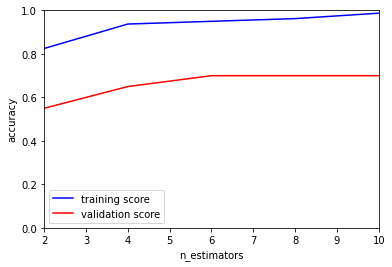

In [20]:
n_estimators = np.arange(2, 12, 2)

train_score, val_score = model_selection.validation_curve(RandomForestClassifier(random_state=0), X_train, y_train, 
                                          param_name='n_estimators', param_range=n_estimators, 
                                          cv=model_selection.KFold(n_splits=5, shuffle=True, random_state=15), 
                                          scoring='accuracy')

plt.plot(n_estimators, np.median(train_score, 1), color='blue', label='training score')
plt.plot(n_estimators, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlim(2, n_estimators[-1])
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.show

This shows precisely the qualitative behavior we expect: the training score is everywhere higher than the validation score; the training score is monotonically improving with increased model complexity; and the validation score reaches a maximum before slightly dropping off as the model becomes over-fit.

From the validation curve, we can read-off that the optimal trade-off between bias and variance is found for a n_estimators=8. Notice that finding this optimal model did not actually require us to compute the training score, but examining the relationship between the training score and validation score can give us useful insight into the performance of the model.

*Note that your results may vary given the stochastic nature of the evaluation procedure or the differences in numerical precision, based on your device. This is just a toy example to introduce use with the concept, practically, in the simplest way as possible.*

### Fine-tuning hyper-parameter values through grid search

The preceding discussion is meant to give you some intuition into the trade-off between bias and variance, and its dependence on model complexity. In practice, models generally have more than one hyper-parameter to turn, and thus plots of validation plots change from lines to multi-dimensional surfaces. In these cases, such visualizations are difficult and we would rather simply find the particular model that maximizes the validation score.

The library scikit-learn provides automated tools to do this in the grid search module. Here is an example of using grid search to find the optimal RandomForest classifier. We will explore a three-dimensional grid of model features; namely the number of estimators, the criterion, and the maximum number of features, for didactic purposes. This can be set up using Scikit-Learn's GridSearchCV meta-estimator. 

Mode details on grid-search can be found in the [scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). 

In [21]:
param_grid = {'n_estimators': np.arange(2, 40 + 1, 5),
              'criterion': ['gini', 'entropy'],
              'max_features': ['auto', 'sqrt', 'log2', None]}

Which other hyper-parameters we could search for? Feel free to add other hyper-parameters above. 

In [22]:
X, y = datasets.make_classification(n_samples=100, n_features=10, n_redundant=0, n_informative=10, class_sep=0.5)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=.8) 

model = RandomForestClassifier(random_state=0)
cv = model_selection.KFold(n_splits=5, shuffle=True, random_state=15)
grid = model_selection.GridSearchCV(model, param_grid, cv=cv, scoring='accuracy')
grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=15, shuffle=True),
             estimator=RandomForestClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 'sqrt', 'log2', None],
                         'n_estimators': array([ 2,  7, 12, 17, 22, 27, 32, 37])},
             scoring='accuracy')

In [23]:
grid.best_params_

{'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 27}

In [24]:
grid.best_estimator_

RandomForestClassifier(criterion='entropy', n_estimators=27, random_state=0)

In [25]:
grid.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_criterion', 'param_max_features', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

## Summary

In this tutorial, we explored evaluation methods and hyperparameter optimization, finally focusing on intuitive aspects of the bias–variance trade-off and how it comes into play when fitting models to data. 